In [7]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import rl_utils
import tqdm

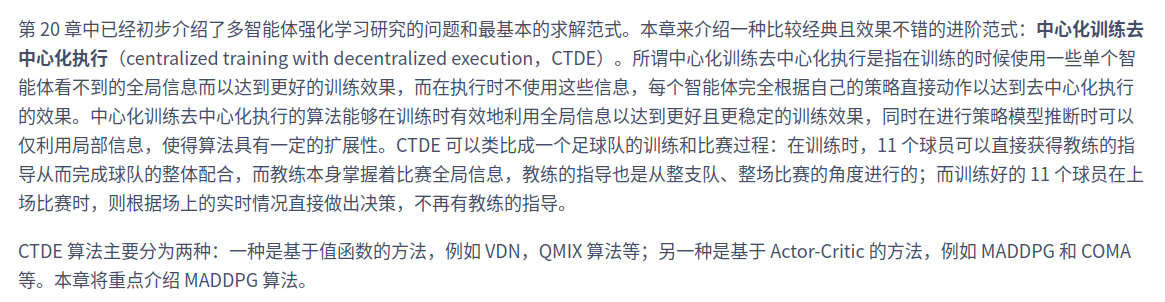  
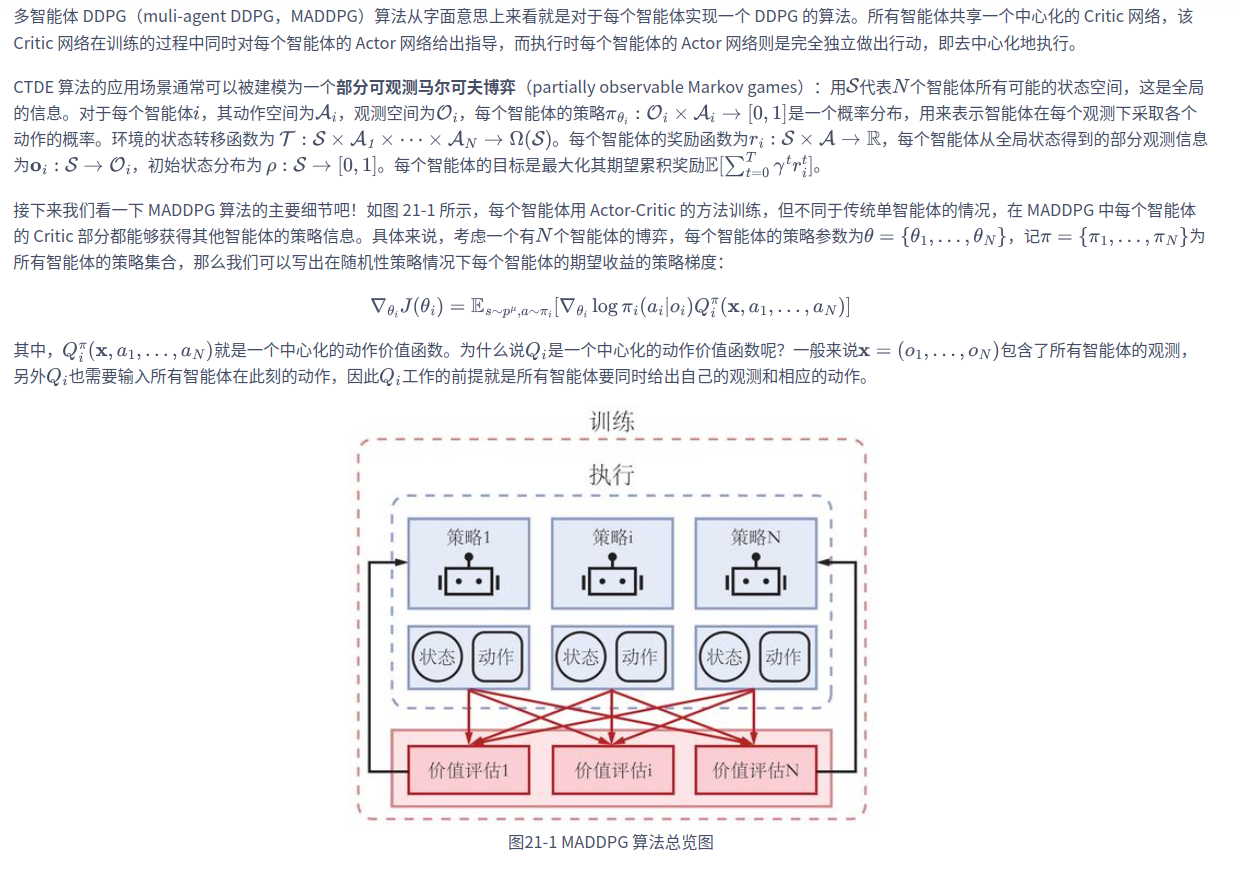  
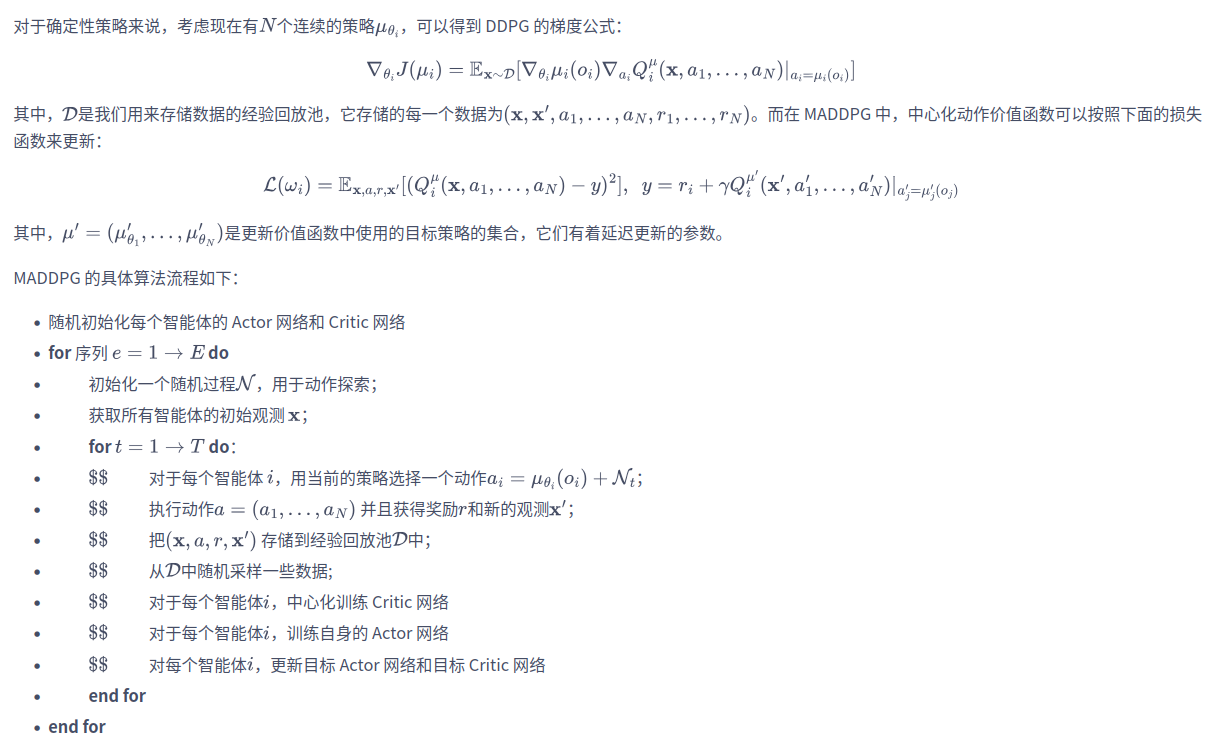  

In [8]:
# !git clone https://github.com/boyu-ai/multiagent-particle-envs.git --quiet
# !pip install -e multiagent-particle-envs
import sys
# sys.path.append("multiagent-particle-envs")
# 由于multiagent-pariticle-env底层的实现有一些版本问题,因此gym需要改为可用的版本
# !pip install --upgrade gym==0.10.5 -q
import gymnasium as gym
from game_env.multiagent.environment import MultiAgentEnv
import game_env.multiagent.scenarios as scenarios

def make_env(scenario_name):
    # 从环境文件脚本中创建环境
    scenario = scenarios.load(scenario_name + ".py").Scenario()
    world = scenario.make_world()
    env = MultiAgentEnv(world, scenario.reset_world, scenario.reward,
                        scenario.observation)
    return env

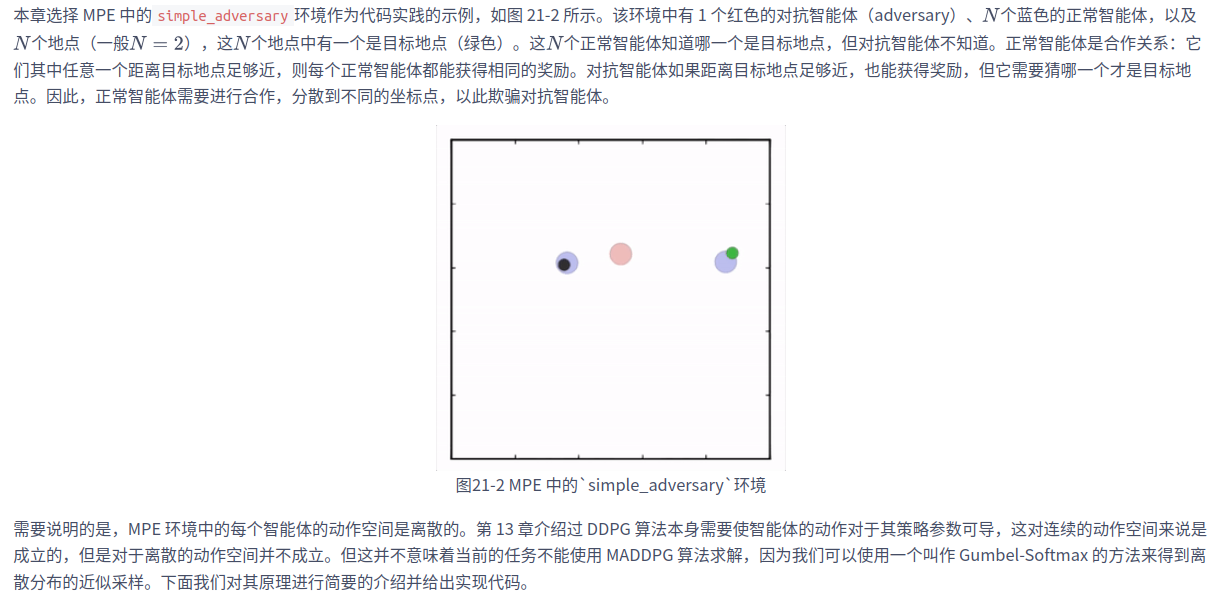  
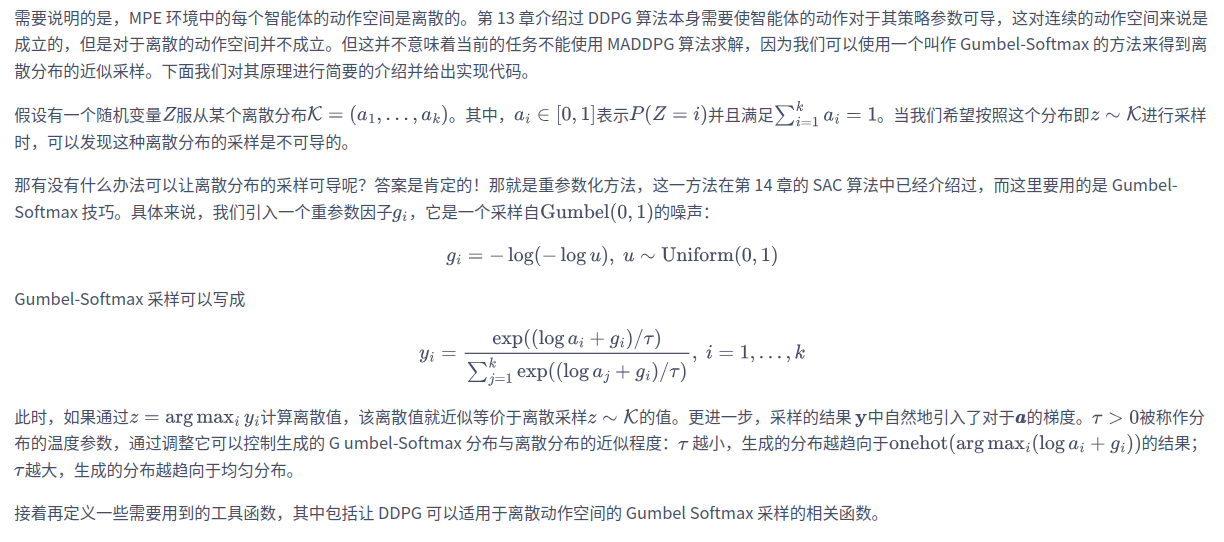  

原离散问题：  
模型输出：  
$$\vec{O}=[p_1,p_2,...,p_n]$$
是每个类别的概率值  
要选取其中最大概率对应的类别，经过argmax，再one-hot  
$$i_o=\underset{i}{argmax}\vec{O}$$
$$\vec{y}=[0,...,0,1,0,...,0] \quad \text{1在第i个位置}$$
这里的$\vec{y}$对$\vec{O}$是不可导的  

Gumbel-Softmax
公式如下：  
$$y_i=\frac{exp(\frac{\log(p_i)+g_i}{\tau})}{\sum\limits^{n}_{j=1} exp(\frac{\log(p_i)+g_i}{\tau})}$$
公式里第一项是log(π)，实际上不需要是真正的 log(π)只需要是 未归一化的 logits（任意实数）  
“log(π)” 只是公式的一种写法，本质上并不要求输入必须是 log(π)  
$y_i$对$\vec{O}$是可导的  
输出$\vec{y}=[y_1,y_2,...,y_i,...,y_n]$对输入$\vec{O}$是可导的  
并且输出$\vec{y}=[y_1,y_2,...,y_i,...,y_n]约等于[0,...,0,1,0,...,0] \quad \text{1在第i个位置}$

In [9]:
def onehot_from_logits(logits, eps=0.01):
    ''' 生成最优动作的独热（one-hot）形式 '''
    # 公式里第一项是log(pi)，实际上不需要是真正的 log(π)只需要是 未归一化的 logits（任意实数）
    # “log(π)” 只是公式的一种写法，本质上并不要求输入必须是 log(π)
    # 输入是二维的(batch_size,num_class)
    # logits.max(1, keepdim=True)返回两个东西，值和索引，[0]变成(batch_size,1)
    argmax_acs = (logits == logits.max(1, keepdim=True)[0]).float()
    # 得到输入离散概率分布的one-hot形式
    # 生成随机动作,转换成独热形式
    # torch.autograd.Variable是 旧版本 PyTorch（0.3 以前）里用于控制自动求导的核心类，现在所有tensor都自带自动求导功能
    rand_acs = torch.autograd.Variable(torch.eye(logits.shape[1])
    # 先构造单位矩阵 I_K（torch.eye(num_class)）， 
    [[np.random.choice(range(logits.shape[1]), size=logits.shape[0])]],
    # 随机生成batch_size个范围在0-num_class的一维数组，(batch_size,)
    # 这些值用来选取I_K对应数值的行，实际上就是索引对应的one-hot
    requires_grad=False).to(logits.device)
    # 最后得到形状为(batch_size,num_class)的随机one-hot矩阵
    # 通过epsilon-贪婪算法来选择用哪个动作
    return torch.stack([
        argmax_acs[i] if r > eps else rand_acs[i]
        # eps的概率随机选择
        for i, r in enumerate(torch.rand(logits.shape[0]))
        # 生成batch_size个[0,1]之间的随机数枚举序列，遍历序列
    ])
    # 默认沿着dim0堆叠

def sample_gumbel(shape, eps=1e-20, tens_type=torch.FloatTensor):
    """从Gumbel(0,1)分布中采样"""
    U = torch.autograd.Variable(tens_type(*shape).uniform_(),requires_grad=False)
    # 均匀分布[0,1],形状为shape的tensor
    return -torch.log(-torch.log(U + eps) + eps)
    # 返回g,形状为(batch_size,num_class)

def gumbel_softmax_sample(logits, temperature):
    """ 从Gumbel-Softmax分布中采样"""
    # 输入是log(p_i),形状为(batch_size,num_class)
    y = logits + sample_gumbel(logits.shape, tens_type=type(logits.data)).to(logits.device)
    return F.softmax(y / temperature, dim=1)
    # (batch_size,num_class)

def gumbel_softmax(logits, temperature=1.0):
    """从Gumbel-Softmax分布中采样,并进行离散化"""
    y = gumbel_softmax_sample(logits, temperature)
    y_hard = onehot_from_logits(y)
    y = (y_hard.to(logits.device) - y).detach() + y
    # 求梯度时，只与后面一项有关，不会考虑随机性
    # 输出时，输出的是有随机性的y_hard
    return y

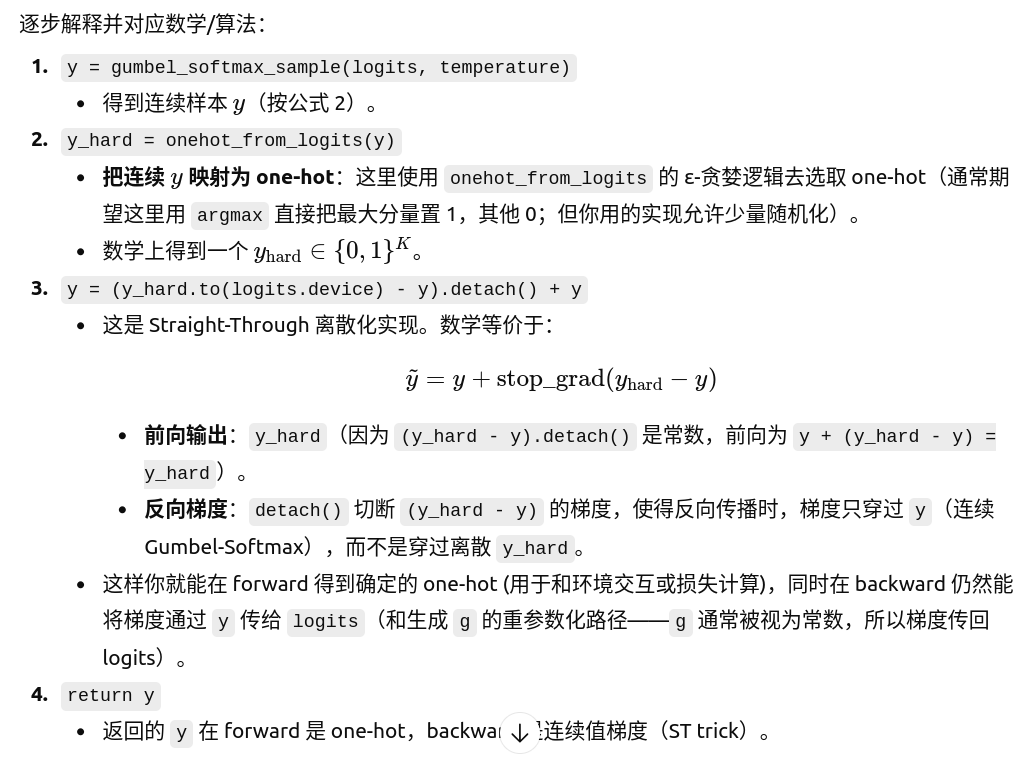

In [10]:
class TwoLayerFC(torch.nn.Module):
    def __init__(self, num_in, num_out, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(num_in, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, num_out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, action_dim, critic_input_dim, hidden_dim,
                 actor_lr, critic_lr, device):
        self.actor = TwoLayerFC(state_dim, action_dim, hidden_dim).to(device)
        self.target_actor = TwoLayerFC(state_dim, action_dim,hidden_dim).to(device)
        
        self.critic = TwoLayerFC(critic_input_dim, 1, hidden_dim).to(device)
        # 输入形状是(batch_size,N*(state_dim+action_dim))
        self.target_critic = TwoLayerFC(critic_input_dim, 1,hidden_dim).to(device)
        
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=critic_lr)

    def take_action(self, state, explore=False):
        action = self.actor(state)
        if explore:
            action = gumbel_softmax(action)
        else:
            action = onehot_from_logits(action)
        return action.detach().cpu().numpy()[0]

    def soft_update(self, net, target_net, tau):
        for param_target, param in zip(target_net.parameters(),net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau)

接下来正式实现一个 MADDPG 类，该类对于每个智能体都会维护一个 DDPG 算法。它们的策略更新和价值函数更新使用的是 21.2 节中关于和的公式给出的形式。

In [11]:
class MADDPG:
    def __init__(self, env, device, actor_lr, critic_lr, hidden_dim,
                 state_dims, action_dims, critic_input_dim, gamma, tau):
        self.agents = []
        for i in range(len(env.agents)):
            self.agents.append(
                DDPG(state_dims[i], action_dims[i], critic_input_dim,
                     hidden_dim, actor_lr, critic_lr, device))
        # critic_input_dim 是所有 agent 的 obs + actions 拼接后的维度（比如 sum(state_dims) + sum(action_dims)）。
        self.env=env
        self.gamma = gamma
        self.tau = tau
        self.critic_criterion = torch.nn.MSELoss()
        self.device = device

    @property
    def policies(self):
        return [agt.actor for agt in self.agents]

    @property
    def target_policies(self):
        return [agt.target_actor for agt in self.agents]
    # 方便获取所有 actors 与 target actors，用于在 update 里计算其他 agent 的动作

    def take_action(self, states, explore):
        states = [
            torch.tensor([states[i]], dtype=torch.float, device=self.device)
            for i in range(len(self.env.agents))
        ]
        return [
            agent.take_action(state, explore)
            for agent, state in zip(self.agents, states)
        ]

    def update(self, sample, i_agent):
        obs, act, rew, next_obs, done = sample
        # (N,batch_size,data_dim)
        """ obs：一个 list 或 tensor，包含每个 agent 的 batch of observations（形状例如 N*(batch_size, state_dim_i)）
        act：每个 agent 的 taken action（one-hot，形状 N*(batch_size, action_dim_i)）
        rew：每个 agent 的 reward（一般 shape N*(batch_size,) 或 N*(batch_size,1)）
        next_obs：下一个状态（同 obs 的格式）
        done：终止标志（0/1），shape N*(batch_size,) """
        cur_agent = self.agents[i_agent]

        cur_agent.critic_optimizer.zero_grad()
        all_target_act = [
            onehot_from_logits(pi(_next_obs))
            # 遍历输入(batch_size,data_dim)输出(batch_size,action_dim)
            for pi, _next_obs in zip(self.target_policies, next_obs)
            # 遍历所有智能体的actor
        ]

        target_critic_input = torch.cat((*next_obs, *all_target_act), dim=1)
        # torch.cat(2N个(batch_size,data_dim),dim=1)->(batch_size,N*state_dim+N*action_dim))
        # 输出形状是(batch_size,N*(state_dim+action_dim))
        # TD_target
        target_critic_value = rew[i_agent].view(-1, 1) 
        # 这里的奖励只是第i个智能体的
        + self.gamma * cur_agent.target_critic(target_critic_input
                                               ) * (1 - done[i_agent].view(-1, 1))
        
        critic_input = torch.cat((*obs, *act), dim=1)
        # 输入s,a,是所有智能体的信息，(batch_size,N*(state_dim+action_dim))
        critic_value = cur_agent.critic(critic_input)
        critic_loss = self.critic_criterion(critic_value,target_critic_value.detach())
        # 最小化TD_error
        critic_loss.backward()
        cur_agent.critic_optimizer.step()
        # 每个智能体自己练自己的critic，使用的是全局信息

        cur_agent.actor_optimizer.zero_grad()
        # actor的输入只是自己的观测值
        cur_actor_out = cur_agent.actor(obs[i_agent])
        # (batch_size,action_dim)
        cur_act_vf_in = gumbel_softmax(cur_actor_out)
        # 可导的argmax,one-hot
        all_actor_acs = []
        for i, (pi, _obs) in enumerate(zip(self.policies, obs)):
            if i == i_agent:
                all_actor_acs.append(cur_act_vf_in)
                # 当前智能体的动作输出考虑了随机性与可导性
            else:
                all_actor_acs.append(onehot_from_logits(pi(_obs)))
                # 其余所有智能体的输出不考虑随机性，并且视为常亮，不求导数

        vf_in = torch.cat((*obs, *all_actor_acs), dim=1)
        actor_loss = -cur_agent.critic(vf_in).mean()
        # 最大化q_value(s,p(s))
        actor_loss += (cur_actor_out**2).mean() * 1e-3
        # logits 的 L2 正则项，用于限制动作 logits 的幅度，使 Gumbel-Softmax 更稳定、策略不过度确定、训练更容易收敛
        actor_loss.backward()
        cur_agent.actor_optimizer.step()

    def update_all_targets(self):
        for agt in self.agents:
            agt.soft_update(agt.actor, agt.target_actor, self.tau)
            agt.soft_update(agt.critic, agt.target_critic, self.tau)

In [12]:
import collections
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) 

    def add(self, state, action, reward, next_state, done): 
        self.buffer.append((state, action, reward, next_state, done)) 
        # 存储元组，每个元组里是所有智能体一步的信息，如state：N个智能体的状态(N,state_dim)

    def sample(self, batch_size): 
        transitions = random.sample(self.buffer, batch_size)
        # 随机采样batch_size个时间步的信息

        # 解压转换数据
        states, actions, rewards, next_states, dones = zip(*transitions)
        # states变成了batch_size*(N,state_dim)
        
        # 将状态和下一个状态转换为列表的列表
        # 每个元素是一个智能体的状态数组
        states = [list(s) for s in states]
        # [[states],[[state1][state2],...],...]
        next_states = [list(ns) for ns in next_states]
        
        return states, actions, rewards, next_states, dones

    def size(self): 
        return len(self.buffer)

In [13]:
num_episodes = 5000
episode_length = 25  # 每条序列的最大长度
buffer_size = 100000
hidden_dim = 64
actor_lr = 1e-2
critic_lr = 1e-2
gamma = 0.95
tau = 1e-2
batch_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
update_interval = 100
minimal_size = 4000

env_id = "simple_adversary"
env = make_env(env_id)
replay_buffer = ReplayBuffer(buffer_size)

state_dims = []#存储每个智能体的状态空间维度
action_dims = []#存储每个智能体的动作空间维度
for action_space in env.action_space:
    action_dims.append(action_space.n)
for state_space in env.observation_space:
    state_dims.append(state_space.shape[0])
critic_input_dim = sum(state_dims) + sum(action_dims)
# critic输入的维度是所有的智能体的状态空间维度加所有的动作空间维度N*(state_dim+action_dim)
maddpg = MADDPG(env, device, actor_lr, critic_lr, hidden_dim, state_dims,
                action_dims, critic_input_dim, gamma, tau)

In [14]:
def evaluate(env_id, maddpg, n_episode=10, episode_length=25):
    # 对学习的策略进行评估,此时不会进行探索
    env = make_env(env_id)
    returns = np.zeros(len(env.agents))
    for _ in range(n_episode):
        obs = env.reset()
        for t_i in range(episode_length):
            actions = maddpg.take_action(obs, explore=False)
            obs, rew, done, info = env.step(actions)
            rew = np.array(rew)
            returns += rew / n_episode
    return returns.tolist()


In [15]:
from tqdm import tqdm
import numpy as np

return_list = []  # 记录每一轮的回报（return）
total_step = 0

# 初始化训练回报记录
train_returns = []
window_size = 100  # 滑动平均窗口大小

# 创建进度条，添加更多显示信息
pbar = tqdm(range(num_episodes), desc="Training", unit="episode")

for i_episode in pbar:
    state = env.reset()
    # state： N个(state_dim_i)数组组成的list [(s1),(s2),...]
    episode_reward = 0  # 记录当前episode的总奖励
    
    for e_i in range(episode_length):
        actions = maddpg.take_action(state, explore=True)
        next_state, reward, done, _ = env.step(actions)
        # next_state： N个(state_dim_i)数组组成的list [(s1),(s2),...]
        replay_buffer.add(state, actions, reward, next_state, done)

        state = next_state
        
        # 累计当前episode的奖励
        episode_reward += np.sum(reward)
        total_step += 1

        # 在训练循环中，使用改进后的数据处理
        if replay_buffer.size() >= minimal_size and total_step % update_interval == 0:
            # 采样，现在返回的是多个列表
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            # 每个变量都是长度 batch_size的列表，里面每一项都是一个长度为 N 的 list,(batch_size,N,state_dim)
            # 定义更清晰的数据重组函数
            def reorganize_multi_agent_data(batch_data, num_agents):
                """
                将一批多智能体数据从 [batch_size, num_agents] 重组为 [num_agents, batch_size]
                batch_data: 一个列表，每个元素是一个包含num_agents个数据的列表或元组。
                num_agents: 智能体的数量。
                """
                # 初始化一个列表，用于存储每个智能体的批量数据
                agent_batches = [[] for _ in range(num_agents)]
                # (batch_size,N,data_dim)->(N,batch_size,data_dim)
                # 遍历批次中的每个样本
                for single_sample in batch_data:
                    # 对于每个样本，遍历其中的每个智能体的数据
                    for agent_id in range(num_agents):
                        agent_batches[agent_id].append(single_sample[agent_id])
                # 将每个智能体的数据列表转换为numpy数组，然后转为Tensor
                return [torch.FloatTensor(np.array(agent_data)).to(device) for agent_data in agent_batches]
            
            num_agents = len(env.agents)
            # 重组各种类型的数据
            states_tensor = reorganize_multi_agent_data(states, num_agents)
            actions_tensor = reorganize_multi_agent_data(actions, num_agents)
            rewards_tensor = reorganize_multi_agent_data(rewards, num_agents)
            next_states_tensor = reorganize_multi_agent_data(next_states, num_agents)
            dones_tensor = reorganize_multi_agent_data(dones, num_agents)
            
            # 将重组后的数据组合成样本元组，供MADDPG更新使用
            sample = (states_tensor, actions_tensor, rewards_tensor, next_states_tensor, dones_tensor)
            
            for a_i in range(num_agents):
                maddpg.update(sample, a_i)
            maddpg.update_all_targets()
    
    # 记录训练回报
    train_returns.append(episode_reward)
    
    # 计算滑动平均回报
    if len(train_returns) >= window_size:
        moving_avg = np.mean(train_returns[-window_size:])
    else:
        moving_avg = np.mean(train_returns) if train_returns else 0
    
    # 更新进度条显示信息
    pbar.set_postfix({
        'Steps': total_step,
        'Buffer': replay_buffer.size(),
        'Reward': f'{episode_reward:.1f}',
        'MA_Reward': f'{moving_avg:.1f}',
        'Buffer_Status': f'{replay_buffer.size()}/{minimal_size}'
    })
    
    # 定期评估模型性能
    if (i_episode + 1) % 100 == 0:
        ep_returns = evaluate(env_id, maddpg, n_episode=100)
        eval_avg_return = np.mean(ep_returns)
        return_list.append(ep_returns)
        # reward包含N个智能体的reward
        
        # 更新进度条前缀（显示最新评估结果）
        pbar.set_description(f"Eval: {eval_avg_return:.1f} | Training")
        
        # 更新进度条后缀（保留其他指标）
        pbar.set_postfix({
            'Steps': total_step,
            'Buffer': replay_buffer.size(),
            'Reward': f'{episode_reward:.1f}',
            'MA_Reward': f'{moving_avg:.1f}',
            'Buffer_Status': f'{replay_buffer.size()}/{minimal_size}'
        })

# 关闭进度条
pbar.close()

Training:   0%|          | 0/5000 [00:00<?, ?episode/s]/tmp/ipykernel_11390/3185090660.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647352509/work/torch/csrc/utils/tensor_new.cpp:278.)
  torch.tensor([states[i]], dtype=torch.float, device=self.device)
Eval: 1.0 | Training: 100%|██████████| 5000/5000 [14:33<00:00,  5.72episode/s, Steps=125000, Buffer=1e+5, Reward=3.0, MA_Reward=1.8, Buffer_Status=100000/4000]    


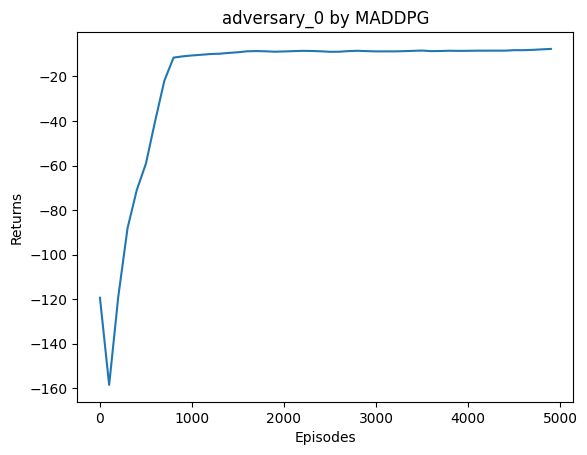

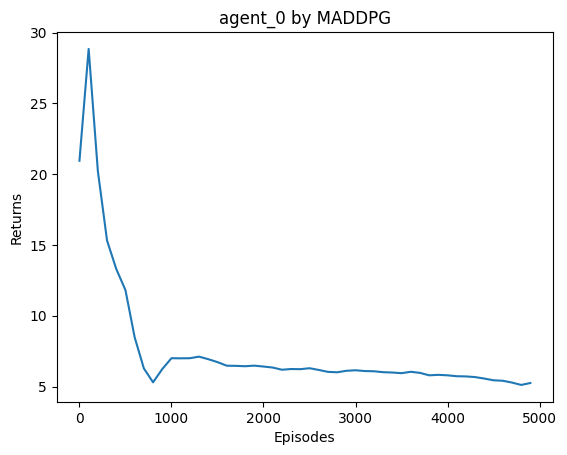

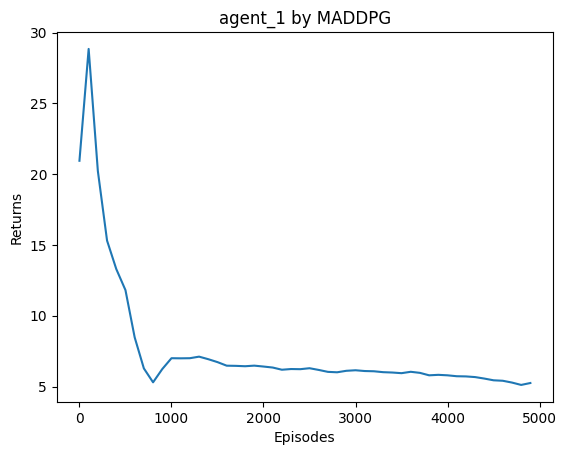

In [16]:
return_array = np.array(return_list)
for i, agent_name in enumerate(["adversary_0", "agent_0", "agent_1"]):
    plt.figure()
    plt.plot(
        np.arange(return_array.shape[0]) * 100,
        rl_utils.moving_average(return_array[:, i], 9))
    plt.xlabel("Episodes")
    plt.ylabel("Returns")
    plt.title(f"{agent_name} by MADDPG")

可以看到，正常智能体agent_0和agent_1的回报结果完全一致，这是因为它们的奖励函数完全一样。正常智能体最终保持了正向的回报，说明它们通过合作成功地占领了两个不同的地点，进而让对抗智能体无法知道哪个地点是目标地点。另外，我们也可以发现 MADDPG 的收敛速度和稳定性都比较不错。


本章讲解了多智能体强化学习 CTDE 范式下的经典算法 MADDPG，MADDPG 后续也衍生了不少多智能体强化学习算法。因此，理解 MADDPG 对深入探究多智能体算法非常关键，有兴趣的读者可阅读 MADDPG 原论文加深理解。